In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210602'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
house_df['부동산유형'] = target_house
print(house_df.shape)
house_df.head()

16it [00:01,  9.36it/s]


(635814, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(633250, 21)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '강동구'
target_dong = '천호동'
target_purpose = '2종일반'
target_building_age = 5
target_period = 36 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(1735, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
12907,서울특별시 강동구 천호동 167-100,성안로27길 57-1,다성이즈빌,19.44,6.29,29300,9,2021.0,0.0,2021-03-06,1507.201646,0.0,연립다세대,대,122.0,준주거지역,지정되지않음,단독,완경사,정방형,세로한면(가),강동구,천호동
12908,서울특별시 강동구 천호동 167-100,성안로27길 57-1,다성이즈빌,19.44,6.29,29200,8,2021.0,0.0,2021-03-06,1502.057613,0.0,연립다세대,대,122.0,준주거지역,지정되지않음,단독,완경사,정방형,세로한면(가),강동구,천호동
14102,서울특별시 강동구 천호동 167-97,성안로27길 57-18,다성이즈빌(167-97),25.77,8.26,27300,10,2017.0,1.0,2018-06-05,1059.371362,4.0,연립다세대,대,122.0,준주거지역,지정되지않음,주거기타,완경사,부정형,세로각지(가),강동구,천호동
14103,서울특별시 강동구 천호동 167-97,성안로27길 57-18,다성이즈빌(167-97),18.13,5.81,22300,12,2017.0,1.0,2018-08-27,1230.005516,4.0,연립다세대,대,122.0,준주거지역,지정되지않음,주거기타,완경사,부정형,세로각지(가),강동구,천호동
14104,서울특별시 강동구 천호동 167-97,성안로27길 57-18,다성이즈빌(167-97),17.03,5.46,20000,12,2017.0,3.0,2020-04-04,1174.398121,4.0,연립다세대,대,122.0,준주거지역,지정되지않음,주거기타,완경사,부정형,세로각지(가),강동구,천호동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(1735, 25)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
12907,서울특별시 강동구 천호동 167-100,성안로27길 57-1,다성이즈빌,19.44,6.29,29300,9,2021.0,0.0,2021-03-06,1507.201646,0.0,연립다세대,대,122.0,준주거지역,지정되지않음,단독,완경사,정방형,세로한면(가),강동구,천호동,1507.201646,2021-03-06
12908,서울특별시 강동구 천호동 167-100,성안로27길 57-1,다성이즈빌,19.44,6.29,29200,8,2021.0,0.0,2021-03-06,1502.057613,0.0,연립다세대,대,122.0,준주거지역,지정되지않음,단독,완경사,정방형,세로한면(가),강동구,천호동,1502.057613,2021-03-06
14102,서울특별시 강동구 천호동 167-97,성안로27길 57-18,다성이즈빌(167-97),25.77,8.26,27300,10,2017.0,1.0,2018-06-05,1059.371362,4.0,연립다세대,대,122.0,준주거지역,지정되지않음,주거기타,완경사,부정형,세로각지(가),강동구,천호동,1287.186102,2021-03-01
14103,서울특별시 강동구 천호동 167-97,성안로27길 57-18,다성이즈빌(167-97),18.13,5.81,22300,12,2017.0,1.0,2018-08-27,1230.005516,4.0,연립다세대,대,122.0,준주거지역,지정되지않음,주거기타,완경사,부정형,세로각지(가),강동구,천호동,1463.027165,2021-03-01
14104,서울특별시 강동구 천호동 167-97,성안로27길 57-18,다성이즈빌(167-97),17.03,5.46,20000,12,2017.0,3.0,2020-04-04,1174.398121,4.0,연립다세대,대,122.0,준주거지역,지정되지않음,주거기타,완경사,부정형,세로각지(가),강동구,천호동,1335.049580,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [19]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 강동구 천호동 112-1,(112-1),5.0,47.57,2020-05-11,35000,735.757831,2021-03-01,822.928547,제2종일반주거지역,연립다세대
1,서울특별시 강동구 천호동 112-1,(112-1),5.0,18.45,2020-05-11,25000,1355.013550,2021-03-01,1515.552110,제2종일반주거지역,연립다세대
2,서울특별시 강동구 천호동 112-1,(112-1),5.0,49.17,2020-05-11,35000,711.816148,2021-03-01,796.150315,제2종일반주거지역,연립다세대
3,서울특별시 강동구 천호동 112-1,(112-1),5.0,49.17,2020-05-11,35000,711.816148,2021-03-01,796.150315,제2종일반주거지역,연립다세대
4,서울특별시 강동구 천호동 112-1,(112-1),5.0,49.17,2020-05-11,35000,711.816148,2021-03-01,796.150315,제2종일반주거지역,연립다세대


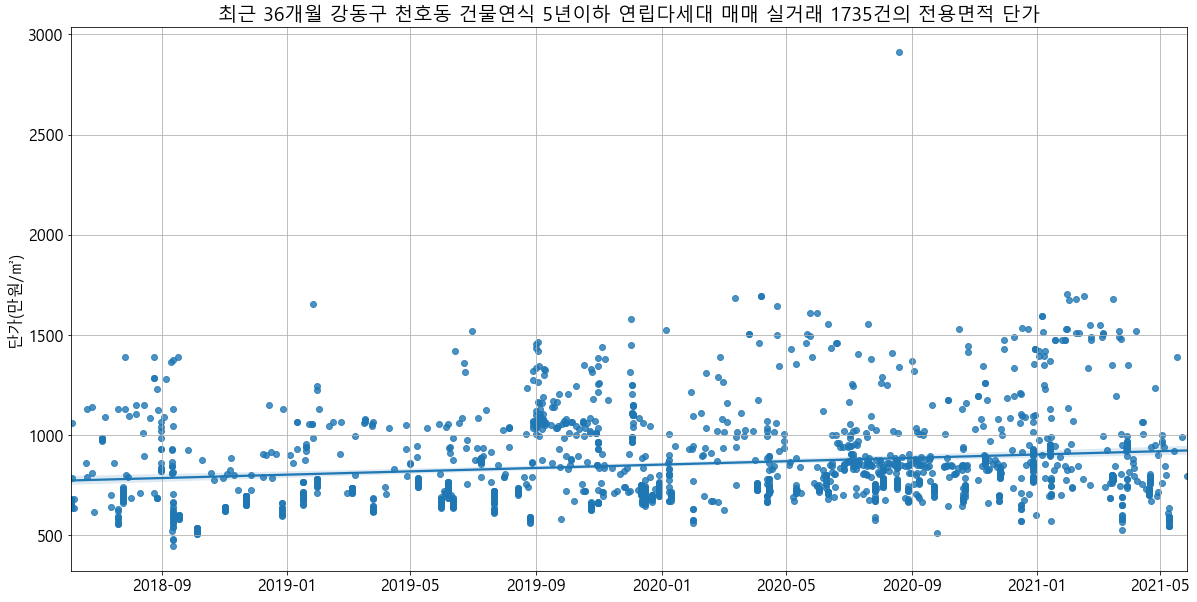

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [21]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

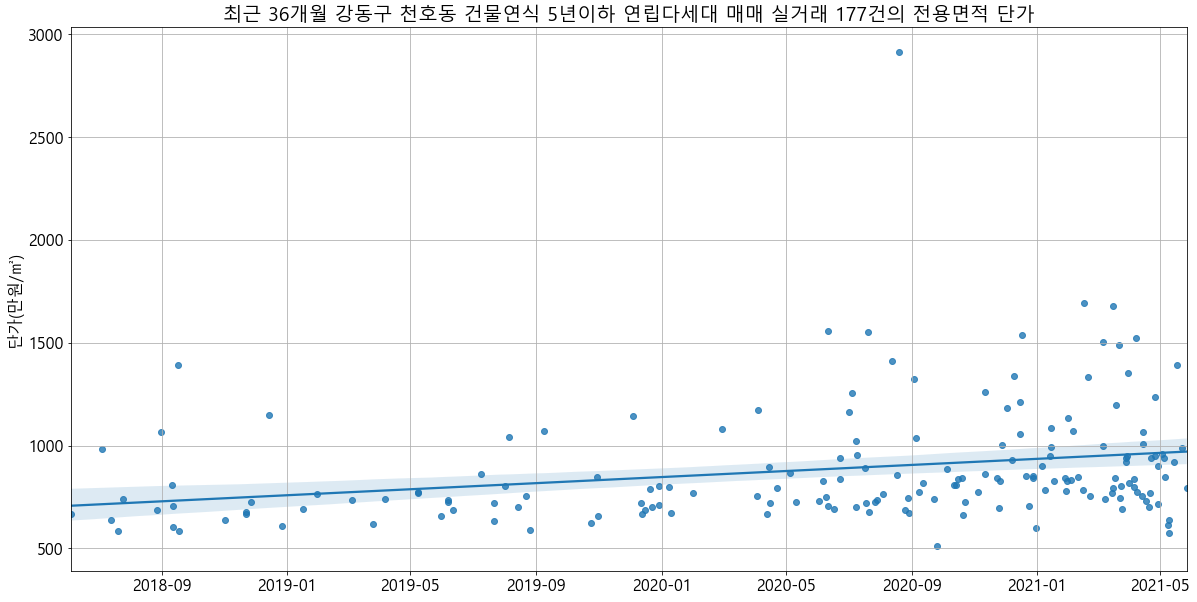

In [22]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [23]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [24]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(4615, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
12898,서울특별시 강동구 천호동 167-100,성안로27길 57-22,(167-100),61.62,37.23,19000,2,2002.0,4.0,2006-08-26,308.341448,19.0,연립다세대,대,122.0,준주거지역,지정되지않음,단독,완경사,정방형,세로한면(가),강동구,천호동
12899,서울특별시 강동구 천호동 167-100,성안로27길 57-22,(167-100),25.44,15.37,12000,1,2002.0,4.0,2006-09-16,471.698113,19.0,연립다세대,대,122.0,준주거지역,지정되지않음,단독,완경사,정방형,세로한면(가),강동구,천호동
12907,서울특별시 강동구 천호동 167-100,성안로27길 57-1,다성이즈빌,19.44,6.29,29300,9,2021.0,0.0,2021-03-06,1507.201646,0.0,연립다세대,대,122.0,준주거지역,지정되지않음,단독,완경사,정방형,세로한면(가),강동구,천호동
12908,서울특별시 강동구 천호동 167-100,성안로27길 57-1,다성이즈빌,19.44,6.29,29200,8,2021.0,0.0,2021-03-06,1502.057613,0.0,연립다세대,대,122.0,준주거지역,지정되지않음,단독,완경사,정방형,세로한면(가),강동구,천호동
12969,서울특별시 강동구 천호동 221-13,천중로27길 38-5,(221-13),66.96,34.94,17000,3,2004.0,2.0,2006-10-15,253.882915,17.0,연립다세대,대,215.0,제2종일반주거지역,지정되지않음,다세대,완경사,삼각형,세로한면(불),강동구,천호동


In [25]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'강동구 천호동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 4615건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

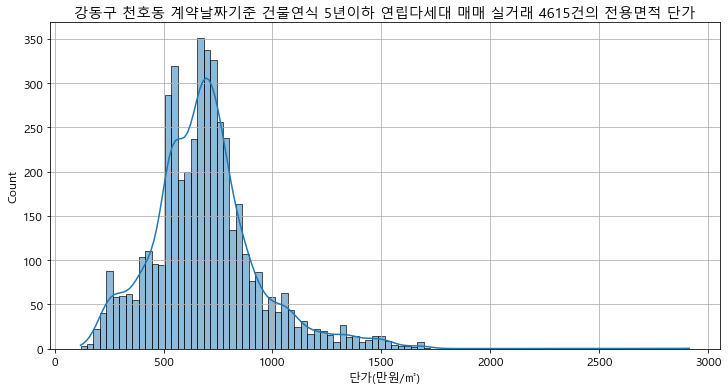

In [26]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [27]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [28]:
concat_df = pd.concat([target_df2])

In [29]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [30]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [31]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(2297, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 강동구 천호동 105-10,천중로29길 16-3,성진아트빌,56.26,35.82,13000,3,2002.0,4.0,2006-07-09,231.070032,19.0,연립다세대,대,136.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로각지(불),강동구,천호동,526.641607,2021-03-01,231.070032,526.641607
1,서울특별시 강동구 천호동 110-3,천중로29길 10,세림 힐 하우스,34.40,21.13,27000,6,2015.0,0.0,2015-10-09,784.883721,6.0,연립다세대,대,67.0,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로각지,강동구,천호동,1076.578378,2021-03-01,729.442963,988.821067
2,서울특별시 강동구 천호동 110-3,천중로29길 10,세림 힐 하우스,34.68,21.31,27300,5,2015.0,0.0,2015-10-12,787.197232,6.0,연립다세대,대,67.0,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로각지,강동구,천호동,1079.751684,2021-03-01,729.442963,988.821067
3,서울특별시 강동구 천호동 110-3,천중로29길 10,세림 힐 하우스,37.74,23.18,27800,6,2015.0,0.0,2015-10-09,736.618972,6.0,연립다세대,대,67.0,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로각지,강동구,천호동,1010.376489,2021-03-01,729.442963,988.821067
4,서울특별시 강동구 천호동 110-3,천중로29길 10,세림 힐 하우스,37.99,23.35,23000,3,2015.0,2.0,2017-09-14,605.422480,6.0,연립다세대,대,67.0,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로각지,강동구,천호동,764.274630,2021-03-01,729.442963,988.821067


In [32]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(575, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 강동구 천호동 105-10,천중로29길 16-3,성진아트빌,56.26,35.82,13000,3,2002.0,4.0,2006-07-09,231.070032,19.0,연립다세대,대,136.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로각지(불),강동구,천호동,526.641607,2021-03-01,231.070032,526.641607
5,서울특별시 강동구 천호동 110-3,천중로29길 10,세림 힐 하우스,38.74,23.81,28400,2,2015.0,0.0,2015-09-19,733.092411,6.0,연립다세대,대,67.0,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로각지,강동구,천호동,1013.124154,2021-03-01,729.442963,988.821067
16,서울특별시 강동구 천호동 110-31,천중로35길 19,드림하우스 천동,40.94,24.87,24700,3,2014.0,5.0,2019-03-05,603.321935,7.0,연립다세대,대,218.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로한면,강동구,천호동,719.016837,2021-03-01,744.978887,1073.604776
24,서울특별시 강동구 천호동 111-34,천중로33길 7,엘림하우스,58.95,35.53,30150,2,2015.0,0.0,2015-12-01,511.450382,6.0,연립다세대,대,340.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(불),강동구,천호동,713.623000,2021-03-01,520.997192,726.943595
30,서울특별시 강동구 천호동 112-1,천중로33길 2-7,(112-1),49.17,33.12,35000,2,2016.0,4.0,2020-05-11,711.816148,5.0,연립다세대,대,132.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),강동구,천호동,796.150315,2021-03-01,860.547663,962.503161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2269,서울특별시 강동구 천호동 87-7,구천면로42가길 5,리츠 하우스,52.39,30.11,27200,4,2016.0,0.0,2016-08-04,519.183050,5.0,연립다세대,대,126.0,제2종일반주거지역,지정되지않음,다세대,완경사,가로장방,세로한면(가),강동구,천호동,687.951939,2021-03-01,516.604614,684.535340
2276,서울특별시 강동구 천호동 90-4,천중로29길 23-8,베일리하우스,58.77,35.92,33200,2,2019.0,0.0,2019-08-26,564.914072,2.0,연립다세대,대,142.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),강동구,천호동,655.855104,2021-03-01,581.473659,675.080488
2286,서울특별시 강동구 천호동 94-2,천중로29길 9,J 하우스,74.53,43.16,35000,5,2016.0,0.0,2016-08-30,469.609553,5.0,연립다세대,대,320.0,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로한면,강동구,천호동,622.263771,2021-03-01,522.755062,692.685092
2287,서울특별시 강동구 천호동 98-27,천중로27길 2,(98-27),45.94,33.10,25000,5,2007.0,0.0,2007-07-27,544.188071,14.0,연립다세대,대,172.0,제2종일반주거지역,지정되지않음,다세대,완경사,사다리형,소로한면,강동구,천호동,903.770738,2021-03-01,544.188071,903.770738


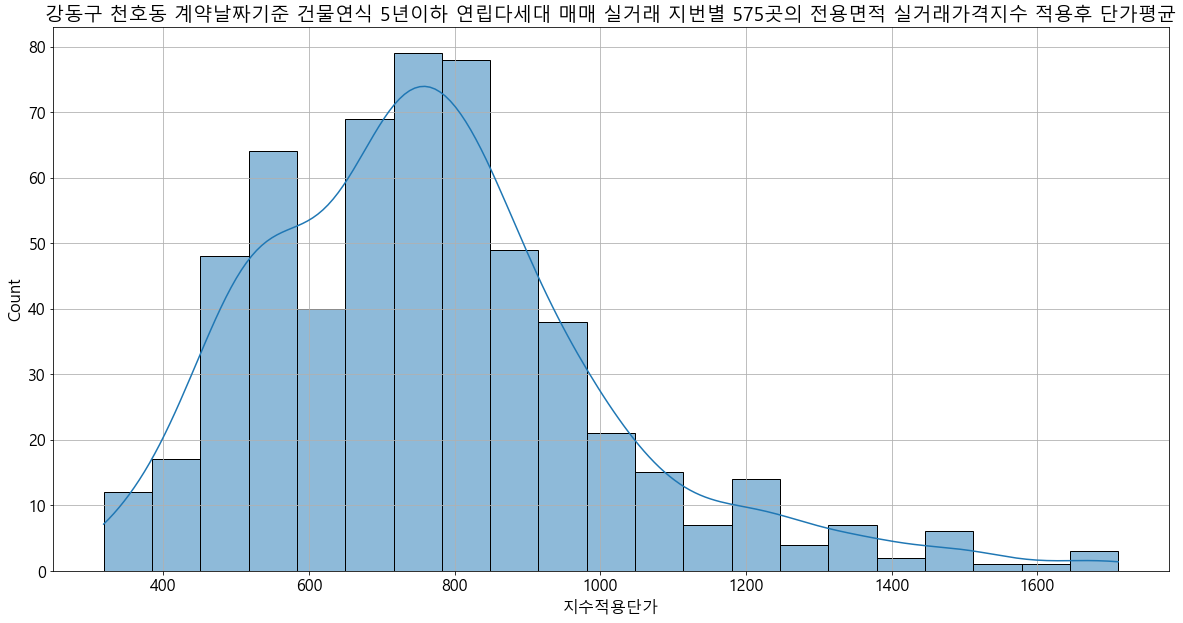

In [33]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [34]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [35]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 강동구 천호동 105-10,성진아트빌,2002.0,56.26,2006-07-09,231.070032,2021-03-01,526.641607,제2종일반주거지역,연립다세대
1,서울특별시 강동구 천호동 110-3,세림 힐 하우스,2015.0,38.74,2015-09-19,733.092411,2021-03-01,1013.124154,제2종일반주거지역,연립다세대
2,서울특별시 강동구 천호동 110-31,드림하우스 천동,2014.0,40.94,2019-03-05,603.321935,2021-03-01,719.016837,제2종일반주거지역,연립다세대
3,서울특별시 강동구 천호동 111-34,엘림하우스,2015.0,58.95,2015-12-01,511.450382,2021-03-01,713.623000,제2종일반주거지역,연립다세대
4,서울특별시 강동구 천호동 112-1,(112-1),2016.0,49.17,2020-05-11,711.816148,2021-03-01,796.150315,제2종일반주거지역,연립다세대


In [36]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)